In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from pyfolio.timeseries import perf_stats
%matplotlib inline

In [2]:
cash = 120000

In [3]:
df = pd.read_csv('/home/tomek/ib_tools/backtests/backtest_2020-09-03_16-58_20180601_20191231_th60_per24_sm10.csv')
del df['sys_time']
del df['exec_ids']
try:
    del df['perm_id']
    del df['com_reports']
except:
    pass
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)
df['cash'] = df.realizedPNL.cumsum() + cash
df['contract'] = df['contract'].apply(lambda x: x[:-2])
df['contract'] = df['contract'].apply(lambda x: x[:2])

In [4]:
#df = df[(df['contract'] == 'NQ') | (df['contract'] == 'ES') | (df['contract'] == 'YM')]

In [5]:
#df = df.loc['20190101':'20190701']

In [6]:
c = set(df['contract'])
allocs = pd.Series([1/len(c)]*len(c) +[1], index=list(c) + ['total'])
#allocs = pd.Series([1/3, 2/3, 1], index=['ES','NQ', 'total'])

In [7]:
allocs

YM       0.25
NQ       0.25
GC       0.25
ES       0.25
total    1.00
dtype: float64

In [8]:
df.groupby('contract').realizedPNL.sum()

contract
ES    16886.40
GC    11629.32
NQ    41778.60
YM    32036.80
Name: realizedPNL, dtype: float64

In [9]:
df.realizedPNL.sum()

102331.12

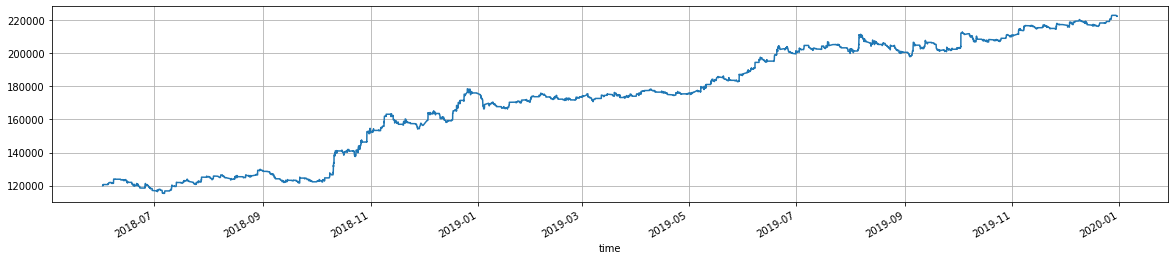

In [10]:
df.cash.plot(figsize=(20,4), grid=True);

In [11]:
by_contract = pd.pivot_table(df, values='realizedPNL', index=df.index, columns=['contract'])
by_contract['total'] = by_contract.sum(axis=1)

In [12]:
# number of trades
trades = df.groupby('contract').action.count()
trades, trades.sum()

(contract
 ES     566
 GC    1055
 NQ    2034
 YM     592
 Name: action, dtype: int64,
 4247)

In [13]:
# trades per day
days = len(by_contract.resample('B').count().index)
trades/days, trades.sum()/days

(contract
 ES    1.373786
 GC    2.560680
 NQ    4.936893
 YM    1.436893
 Name: action, dtype: float64,
 10.308252427184467)

In [14]:
# commission paid
df.groupby('contract').commission.sum()

contract
ES    1188.6
GC    2553.1
NQ    4271.4
YM    1243.2
Name: commission, dtype: float64

In [15]:
df.commission.sum()

9256.300000000001

In [16]:
# per trade stats
exits = df[df.realizedPNL!=0]
dfs = {}
for contract in exits.contract.unique():
    dfs[contract] = exits[exits.contract == contract]
dfs['total'] = exits
results = pd.DataFrame(columns=['success_rate', 'average_PNL', 'average_gain', 'average_loss','win_ratio', 'EV',
                               'number_of_positions'])
for c, d in dfs.items():
    row = pd.Series()
    row['success_rate'] = round((d[d.realizedPNL > 0]).realizedPNL.count() / d.realizedPNL.count(), 2)
    row['average_PNL'] = round(d.realizedPNL.mean(), 2)
    row['average_gain'] = round((d[d.realizedPNL > 0]).realizedPNL.mean(), 2)
    row['average_loss'] = round((d[d.realizedPNL < 0]).realizedPNL.mean(), 2)
    row['win_ratio'] = round(abs(row['average_gain'] / row['average_loss']), 2)
    row['EV'] = round((row['average_gain'] * row['success_rate']) + (
        row['average_loss'] * (1 - row['success_rate'])), 2)
    row['number_of_positions'] = d.realizedPNL.count()
    results.loc[c] = row
results

,success_rate,average_PNL,average_gain,average_loss,win_ratio,EV,number_of_positions
GC,0.39,22.07,458.35,-253.48,1.81,24.13,527.0
NQ,0.41,41.08,462.61,-250.70,1.85,41.76,1017.0
ES,0.41,59.67,910.02,-531.00,1.71,59.82,283.0
YM,0.42,108.23,765.88,-365.89,2.09,109.45,296.0
total,0.41,48.20,565.68,-304.16,1.86,52.47,2123.0


In [17]:
daily = by_contract.resample('B').sum()
daily = daily /  (allocs * cash)
#daily[['CL', 'ES', 'GC', 'NQ']].plot(figsize=(20,8), grid=True);

In [18]:
# instrument correlations
log_returns = np.log(daily + 1)
log_returns.corr()

,ES,GC,NQ,YM,total
ES,1.000000,0.034845,0.160725,0.503390,0.718552
GC,0.034845,1.000000,0.083561,0.036744,0.372500
NQ,0.160725,0.083561,1.000000,0.237332,0.641584
YM,0.503390,0.036744,0.237332,1.000000,0.724026
total,0.718552,0.372500,0.641584,0.724026,1.000000


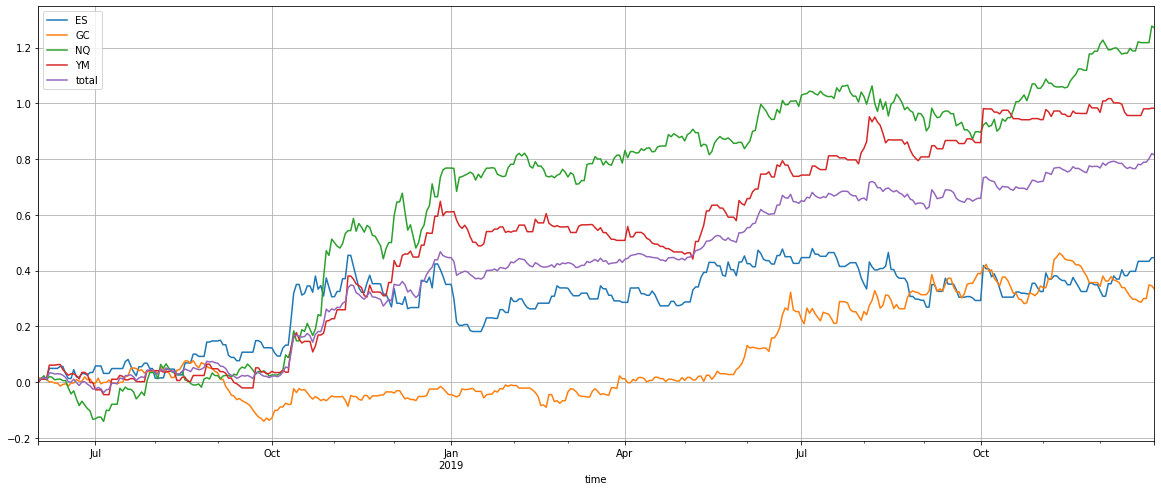

In [19]:
log_returns.cumsum().plot(figsize=(20,8), grid=True);

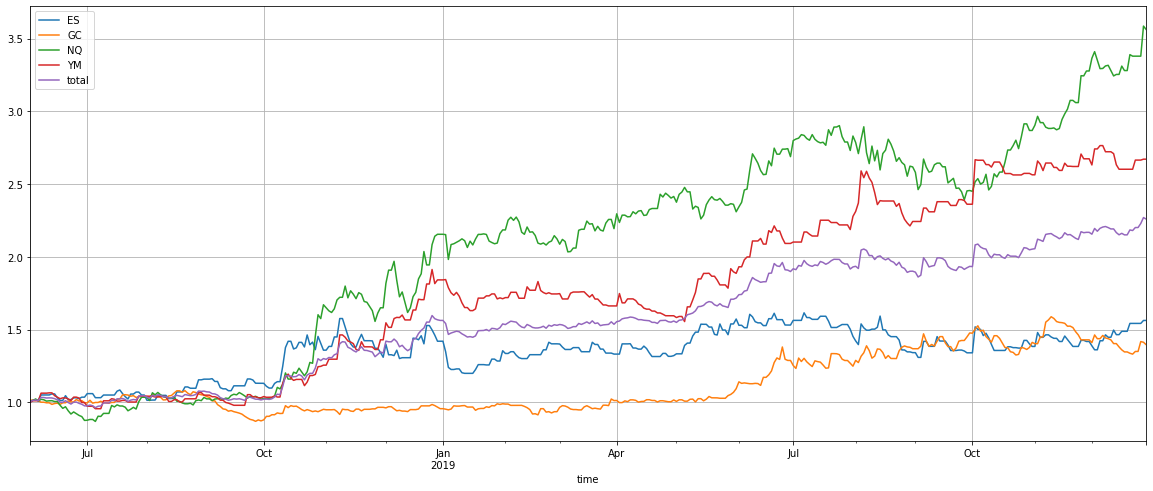

In [20]:
returns = daily.copy()
returns_index = (returns + 1).cumprod()
returns_index.plot(figsize=(20,8), grid=True);

In [21]:
stats = pd.DataFrame()
for col in daily.columns:
    stats[col] = perf_stats(daily[col])
stats

,ES,GC,NQ,YM,total
Annual return,0.313789,0.226002,1.174887,0.823745,0.646160
Cumulative returns,0.562356,0.395327,2.561903,1.670888,1.258993
Annual volatility,0.382404,0.259962,0.387563,0.326879,0.215016
Sharpe ratio,0.900319,0.912065,2.197826,1.998223,2.425824
Calmar ratio,1.312216,1.157786,6.579196,4.403080,6.897350
Stability,0.579365,0.679285,0.872365,0.933305,0.947235
Max drawdown,-0.239129,-0.195202,-0.178576,-0.187084,-0.093682
Omega ratio,1.221059,1.189916,1.511089,1.628340,1.615669
Sortino ratio,1.646140,1.628620,3.978343,4.638011,5.188516
Skew,1.519405,1.203770,0.980944,2.352526,1.833162


In [22]:
# monthly returns in percent
monthly_log_returns = log_returns.resample('M').sum()
monthly_returns = np.exp(monthly_log_returns)-1
round(monthly_returns, 4) * 100

,ES,GC,NQ,YM,total
time,,,,,
2018-06-30,3.50,-0.40,-12.48,-0.17,-2.47
2018-07-31,1.42,4.39,18.22,4.45,7.13
2018-08-31,10.40,-0.06,-1.08,0.59,2.55
2018-09-30,-2.42,-16.08,-0.16,-1.69,-5.19
2018-10-31,20.09,9.13,63.45,21.73,27.98
2018-11-30,-3.60,1.44,-1.24,13.88,2.88
2018-12-31,8.42,-0.97,30.63,28.82,16.81
2019-01-31,-4.60,3.54,1.39,-7.03,-1.54
2019-02-28,3.50,-5.50,-2.82,1.92,-0.62


In [23]:
# total returns by contract in percent
round(np.exp(monthly_log_returns.sum())-1, 2)* 100

ES        56.0
GC        40.0
NQ       256.0
YM       167.0
total    126.0
dtype: float64

In [24]:
df.sort_values('realizedPNL', ascending=False)[['contract', 'action', 'price', 'realizedPNL']]

,contract,action,price,realizedPNL
time,,,,
2019-10-02 21:00:00,ES,BUY,2893.75,3995.80
2019-10-02 20:45:00,YM,BUY,26061.00,3885.80
2018-11-08 20:40:30,YM,SELL,26087.00,3860.80
2018-10-11 04:24:00,ES,BUY,2767.00,3395.80
2019-06-20 03:04:00,GC,SELL,1392.40,3105.16
...,...,...,...,...
2018-10-26 21:50:00,ES,BUY,2669.50,-1216.70
2018-12-10 13:56:30,ES,BUY,2638.75,-1329.20
2018-12-26 11:04:00,ES,BUY,2360.75,-1454.20


In [25]:
daily.sort_values('total', ascending=False)

,ES,GC,NQ,YM,total
time,,,,,
2019-10-02,0.133193,0.019355,0.026633,0.129527,0.077177
2019-08-05,0.101803,0.034011,0.035793,0.093053,0.066165
2018-10-11,0.102773,0.057183,0.068633,0.035940,0.066132
2019-09-05,0.084027,0.061011,0.070387,0.041053,0.064119
2018-12-03,0.067777,-0.003989,0.101747,0.081860,0.061849
...,...,...,...,...,...
2018-11-27,-0.035973,0.000000,-0.045253,-0.012307,-0.023383
2018-12-10,-0.042363,0.003172,-0.061173,-0.000780,-0.025286
2018-11-13,-0.038890,0.000011,-0.044980,-0.017613,-0.025368
